In [1]:
import sigtech.framework as sig
import numpy as np
import pandas as pd
import datetime as dtm
import seaborn as sns

sns.set(rc={'figure.figsize': (18, 6)})

from sigtech.framework.default_strategy_objects.rolling_futures import cl_comdty_f_0
from sigtech.framework.signal.library.momentum import simple_ma_signal, ma

sig.init()

SigTech environment successfully initialized


## Pre-built Crude Oil Rolling Futures Strategy

In [2]:
cl = cl_comdty_f_0()
cl_price_history = cl_comdty_f_0().history()

## WMA Function

In [3]:
def wma(window, ts, weighting='linear'):
    # Convert to a Pandas Series if it's not already
    if not isinstance(ts, pd.Series):
        ts = pd.Series(ts)

    # Define a function to calculate the linear weighted mean
    def linear_weighted_mean(data):
        weights = np.arange(1, window + 1)
        return np.sum(data * weights) / np.sum(weights)

    # Define a function to calculate the exponential weighted mean
    def exponential_weighted_mean(data):
        weights = np.exp(np.linspace(-1, 0, window))
        return np.sum(data * weights) / np.sum(weights)

    # Choose the weighting function based on the parameter
    if weighting == 'linear':
        weighted_mean_function = linear_weighted_mean
    elif weighting == 'exponential':
        weighted_mean_function = exponential_weighted_mean
    else:
        raise ValueError("Invalid weighting type. Choose 'linear' or 'exponential'.")

    # Apply the chosen weighted mean function over the rolling window
    return ts.rolling(window=window).apply(weighted_mean_function, raw=False)


## HMA Function

In [4]:
def hma(window, ts):
    
    # Calculate weighted moving averages
    wma1 = wma(int(window//2), ts)
    wma2 = wma(window, ts)
    
    r_hma = (2*wma1)-wma2
 
    hma = wma(int(np.floor(np.sqrt(window))),r_hma)
    
    return hma


## Create a Signal DF

In [5]:
# Define helper function

def signal_generation(short_span, long_span, wma_span, df):
    '''
    returns a dataframe of indicators
    '''
    short_ma = hma(short_span, df.dropna())
    long_ma = hma(long_span, df.dropna())
    # cross_signal = np.sign(simple_ma_signal(short_span, long_span, df.dropna()))
    cross_signal = np.sign(simple_ma_signal(short_span, long_span, df.dropna()))    
    wma_price = wma(wma_span, df)
    price_history = df

    return pd.DataFrame({
        'short_ma':short_ma, 
        'long_ma':long_ma, 
        'cross_signal':cross_signal, 
        'wma_price':wma_price,
        'price_history': price_history}
    ).dropna()


def signal_function(row):
    '''
    returns signal for long/short/close
    '''
    if row['cross_signal'] > 0:
        return 1 if row['price_history'] > row['wma_price'] else 0
    else:
        return 0 if row['price_history'] > row['wma_price'] else -1    
    

In [6]:
signal_df = signal_generation(6,25,80,cl_price_history)
signal_df

,short_ma,long_ma,cross_signal,wma_price,price_history
2010-04-28,980.046309,991.174727,-1.0,973.540021,984.283212
2010-04-29,989.584287,989.012065,-1.0,974.696659,1007.365274
2010-04-30,1010.527475,989.314401,-1.0,976.137520,1018.968339
2010-05-03,1024.631276,991.857718,-1.0,977.584613,1019.457838
2010-05-04,1007.993368,993.145947,-1.0,978.041677,979.502836
...,...,...,...,...,...
2023-08-30,491.881958,478.847132,-1.0,461.442017,492.044517
2023-08-31,500.074633,481.544344,1.0,462.848017,504.128712
2023-09-01,511.791551,486.249866,1.0,464.518479,515.734216
2023-09-05,523.300892,492.642467,1.0,466.350857,523.290213


In [7]:
trade_df = signal_df.apply(signal_function,axis=1).to_frame(cl.name)
trade_df = trade_df[trade_df!=trade_df.shift()].dropna()
trade_df

,USD CL COMDTY LONG F_0 RF STRATEGY
2010-04-28,0.0
2010-05-05,-1.0
2010-06-15,0.0
2010-07-02,-1.0
2010-07-20,0.0
...,...
2023-06-12,-1.0
2023-07-05,0.0
2023-07-07,1.0
2023-08-23,0.0


## Helper class to create a dynamic strategy

In [8]:
from typing import Optional

class DynamicStrategy(sig.DailyStrategy):
    trade_frequency: Optional[str] = 'EOM'
    trade_dictionary: Optional[dict] = {}
    basket_creation_method: Optional[object] = None
    basket_creation_kwargs: Optional[dict] ={}
    
    def __post_init__(self):
        
        self.trade_dates = []
        super().__post_init__()
        if len(self.trade_dictionary) > 0:
            self.trade_dates = sorted(self.trade_dictionary.keys())
        else:
            self.trade_dates = self.create_schedule()
    
    def strategy_initialization(self, dt):
        """
        Initial decision run on the start date of the strategy.

        :param dt: Reference datetime.
        """

        for d in self.trade_dates:
            self.add_method(d, self.set_positions)
    
    def create_schedule(self):
        return sig.SchedulePeriodic(
            self.calculation_start_date(),
            self.calculation_end_date(),
            'NYM (T)',
            frequency=self.trade_frequency
        ).data_dates()[1:]

        
        return entry_dates
    
    def _basket_creation_method(self, strategy: object, dt: dtm.datetime, positions: str, **basket_creation_kwargs: dict):
        return self.basket_creation_method(strategy, dt, positions, **basket_creation_kwargs)
    
    
    def set_positions(self, dt):
        """
        Set instrument positions.
        :param dt: Decision datetime.
        """
        d = dt.date()
        if self.basket_creation_method is None:
            instruments = self.trade_dictionary.get(d, {})
        else:
            positions = self.strategy_timeline.holdings.positions(dt)
            instruments = self._basket_creation_method(self, dt, positions, **self.basket_creation_kwargs)

        if isinstance(instruments, dict):
            instruments = tuple(instruments.items())

        if len(instruments) > 0:
            for inst, weight in instruments:
                self.add_position_target(self.execution_dt_from_date(inst, dt), inst.name, weight)
            

In [9]:
def basket_creation_method(strategy, dt, positions, **additional_parameters):
    
    inst = additional_parameters.get('inst')
    signals = additional_parameters.get('signals')
    size_date = strategy.size_date_from_decision_dt(dt)
    weight = 0.0
    
    # i have a signal, open/close trade
    if pd.Timestamp(dt.date()) in signals.index:
        if signals.loc[pd.Timestamp(dt.date())] == 1:
            weight = 1.0            
        elif signals.loc[pd.Timestamp(dt.date())] == -1:
            weight = -1.0
        else:
            weight = 0.0
    else: # no signal, check underlying contract price changes
        # if I current have a position
        if inst.name in strategy.positions.get_exposure_weight(dt).keys():
            
            # get contract and current weight
            underlying_inst = strategy.positions.iterate_bottom_instruments(dt)[0][0]
            weight = strategy.positions.get_exposure_weight(dt).get(inst.name)
            
            # Fetch the contract price data
            open_price_latest = underlying_inst.history('OpenPrice')[-1]
            high_price_prev = underlying_inst.history('HighPrice')[-2]
            low_price_prev = underlying_inst.history('LowPrice')[-2]            

            if (weight >= 0 and open_price_latest > high_price_prev) or (weight < 0 and open_price_latest < low_price_prev):
                weight = weight * 0.8
            else:
                print(f'{dt} - {inst.name} - no changes')
                return {}
            
    print(f'{dt} - {inst.name} - {weight}')
    return {inst: weight}

In [10]:
dynamic_strategy = DynamicStrategy(
    currency = 'USD',
    # start_date = dtm.date(2015,12,10),
    start_date = trade_df.first_valid_index(),
    trade_frequency = '1BD',
    basket_creation_method = basket_creation_method,    
    basket_creation_kwargs = {'signals':trade_df.squeeze(), 'inst':cl},
    unit_type='WEIGHT',
    total_return = False,
    initial_cash=1e6,
)

In [11]:
dynamic_strategy.build(progress=True)

  0%|          | 0/100 [00:00<?, ?it/s]

2010-04-29 06:30:00+00:00 - USD CL COMDTY LONG F_0 RF STRATEGY - 0.0
2010-04-30 06:30:00+00:00 - USD CL COMDTY LONG F_0 RF STRATEGY - 0.0
2010-05-03 06:30:00+00:00 - USD CL COMDTY LONG F_0 RF STRATEGY - 0.0
2010-05-04 06:30:00+00:00 - USD CL COMDTY LONG F_0 RF STRATEGY - 0.0
2010-05-05 06:30:00+00:00 - USD CL COMDTY LONG F_0 RF STRATEGY - -1.0
2010-05-06 06:30:00+00:00 - USD CL COMDTY LONG F_0 RF STRATEGY - no changes
2010-05-07 06:30:00+00:00 - USD CL COMDTY LONG F_0 RF STRATEGY - no changes
2010-05-10 06:30:00+00:00 - USD CL COMDTY LONG F_0 RF STRATEGY - no changes
2010-05-11 06:30:00+00:00 - USD CL COMDTY LONG F_0 RF STRATEGY - no changes
2010-05-12 06:30:00+00:00 - USD CL COMDTY LONG F_0 RF STRATEGY - no changes
2010-05-13 06:30:00+00:00 - USD CL COMDTY LONG F_0 RF STRATEGY - no changes
2010-05-14 06:30:00+00:00 - USD CL COMDTY LONG F_0 RF STRATEGY - no changes
2010-05-17 06:30:00+00:00 - USD CL COMDTY LONG F_0 RF STRATEGY - no changes
2010-05-18 06:30:00+00:00 - USD CL COMDTY LONG

In [12]:
df = dynamic_strategy.inspect.bottom_trades_df()
df[df['valuation']>1].head(10)

,instrument_name,display_name,trade_size,payment_currency,transaction_type,valuation,trade_price
dt,,,,,,,
2010-05-05 18:30:00+00:00,CLN10 COMDTY,CLN10 COMDTY,-11773.329121,USD,outright,82.99,82.99
2010-06-01 18:30:00+00:00,CLN10 COMDTY,CLN10 COMDTY,5886.664560,USD,roll,72.58,72.58
2010-06-01 18:30:00+00:00,CLQ10 COMDTY,CLQ10 COMDTY,-5729.947347,USD,roll,73.90,73.90
2010-06-02 18:30:00+00:00,CLN10 COMDTY,CLN10 COMDTY,5886.664560,USD,roll,72.86,72.86
2010-06-02 18:30:00+00:00,CLQ10 COMDTY,CLQ10 COMDTY,-5729.947347,USD,roll,74.50,74.50
2010-06-15 18:30:00+00:00,CLQ10 COMDTY,CLQ10 COMDTY,11459.894694,USD,outright,77.91,77.91
2010-07-02 18:30:00+00:00,CLU10 COMDTY,CLU10 COMDTY,-14679.324996,USD,outright,72.60,72.60
2010-07-20 18:30:00+00:00,CLU10 COMDTY,CLU10 COMDTY,14679.324996,USD,outright,77.58,77.58
2010-07-22 18:30:00+00:00,CLU10 COMDTY,CLU10 COMDTY,13123.870073,USD,outright,79.30,79.30


,Strategy,Benchmark
Annualised Excess Return,4.96%,-4.55%
Annualised Standard Deviation,27.27%,41.45%
Annualised Sharpe Ratio (vs Cash),0.307,0.101
Annualised Sortino Ratio (vs Cash),0.503,0.155
Max Drawdown,-59.51%,-94.24%
Kurtosis,14.931,32.101
Skewness,0.859,-0.970
Mean Positive Return,1.23%,1.62%
Mean Negative Return,-1.25%,-1.74%
Proportion Positive Returns,45.02%,52.22%


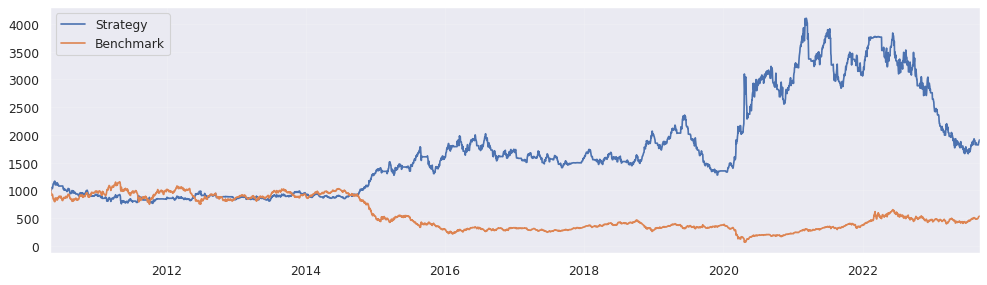

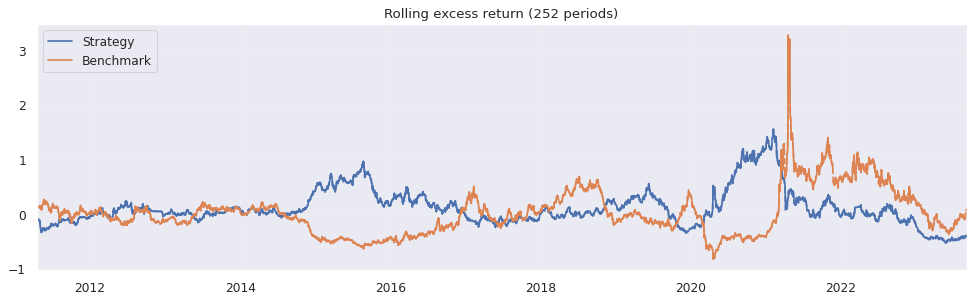

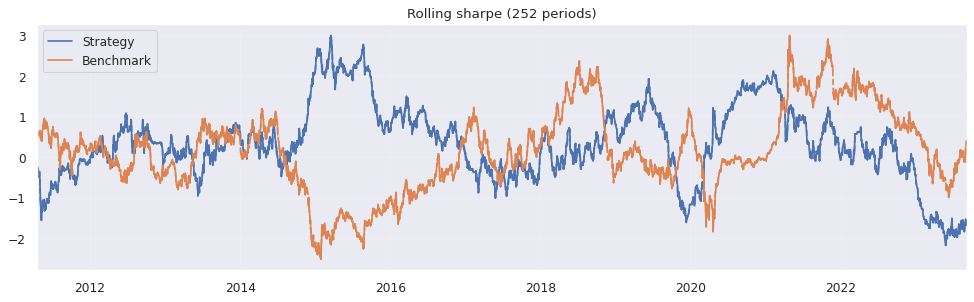

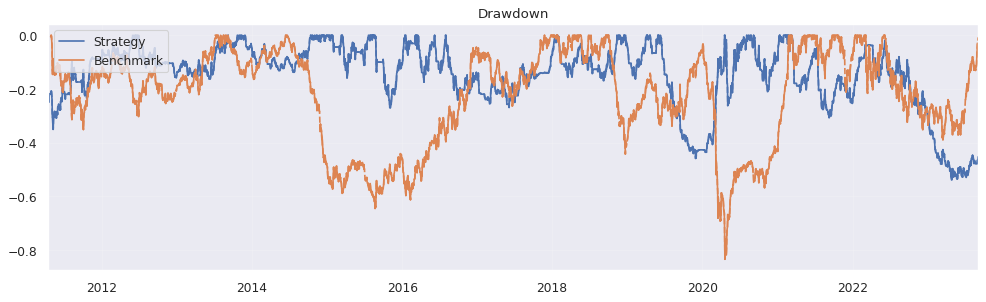

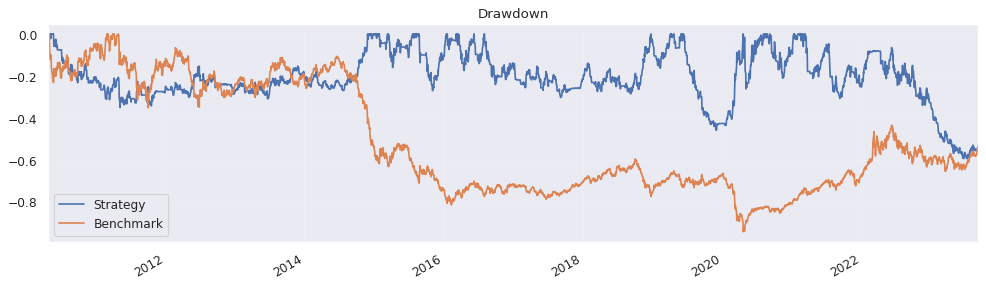

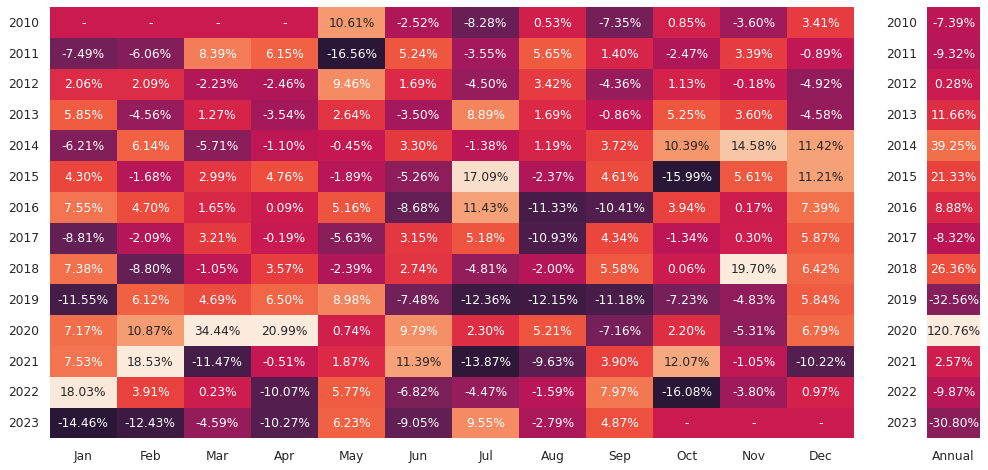

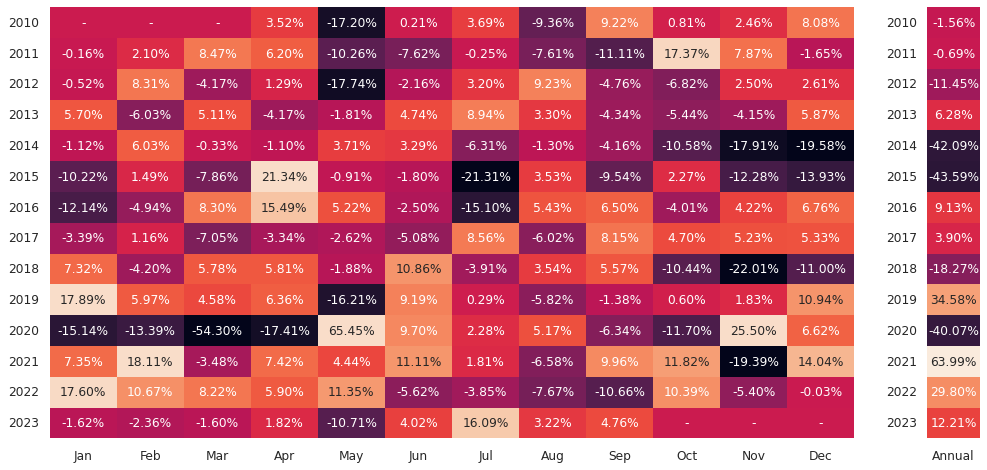

In [13]:
sig.PerformanceReport(dynamic_strategy, benchmark=cl.history()).report()